In [ ]:
!pip install torch nltk numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import nltk
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import pickle
import os

# Download the Brown corpus if not already downloaded
nltk.download('brown')
nltk.download('punkt')

class ELMoEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(ELMoEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Projection layer to match dimensions
        self.embedding_projection = nn.Linear(embedding_dim, hidden_dim * 2)

        # Bidirectional LSTM layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(hidden_dim * 2 if i == 0 else hidden_dim * 2,
                   hidden_dim, batch_first=True, bidirectional=True)
            for i in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

        # Parameters for the weighted sum of LSTM layers
        self.gamma = nn.Parameter(torch.ones(1))
        self.weights = nn.Parameter(torch.ones(num_layers + 1))

        # Linear layers for forward and backward language model
        self.forward_linear = nn.Linear(hidden_dim, vocab_size)
        self.backward_linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs, return_embeddings=False):
        batch_size, seq_len = inputs.size()

        # Get word embeddings
        embeddings = self.word_embeddings(inputs)  # [batch, seq_len, embedding_dim]

        # Project embeddings to match LSTM dimensions
        projected_embeddings = self.embedding_projection(embeddings)  # [batch, seq_len, hidden_dim * 2]

        layer_outputs = [projected_embeddings]

        # Pass through LSTM layers
        lstm_output = projected_embeddings
        for lstm in self.lstm_layers:
            lstm_output, _ = lstm(self.dropout(lstm_output))
            layer_outputs.append(lstm_output)

        if return_embeddings:
            # Normalize weights
            norm_weights = nn.functional.softmax(self.weights, dim=0)

            # All tensors should now have size (batch, seq_len, hidden_dim * 2)
            weighted_sum = sum(w * tensor for w, tensor in zip(norm_weights, layer_outputs))

            # Scale with gamma
            elmo_embeddings = self.gamma * weighted_sum
            return elmo_embeddings
        else:
            # Extract forward and backward hidden states
            forward_hidden = lstm_output[:, :, :self.hidden_dim]
            backward_hidden = lstm_output[:, :, self.hidden_dim:]

            # Calculate forward and backward language model predictions
            forward_logits = self.forward_linear(forward_hidden)
            backward_logits = self.backward_linear(backward_hidden)
            return forward_logits, backward_logits

class ELMoDataset(Dataset):
    def __init__(self, sentences, word_to_idx, max_len=40):
        self.sentences = sentences
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        self.pad_idx = word_to_idx['<PAD>']
        self.unk_idx = word_to_idx['<UNK>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        # Convert words to indices
        indices = [self.word_to_idx.get(word, self.unk_idx) for word in sentence]

        # Truncate or pad sequence to max_len
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [self.pad_idx] * (self.max_len - len(indices))

        # Create inputs and targets
        inputs = torch.tensor(indices, dtype=torch.long)

        # Forward targets: next word (shifted right, pad at end)
        forward_targets = torch.tensor(indices[1:] + [self.pad_idx], dtype=torch.long)

        # Backward targets: previous word (shifted left, pad at start)
        backward_targets = torch.tensor([self.pad_idx] + indices[:-1], dtype=torch.long)

        return inputs, forward_targets, backward_targets


def preprocess_brown_corpus(min_freq=5, max_vocab_size=30000):
    sentences = []
    for fileid in brown.fileids():
        for sent in brown.sents(fileid):
            # Convert words to lowercase individually and tokenize
            sentences.append([word.lower() for word in sent])

    # Count word frequencies
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update(sentence)

    # Create vocabulary
    vocab = ['<PAD>', '<UNK>']
    for word, count in word_counts.most_common(max_vocab_size - 2):
        if count >= min_freq:
            vocab.append(word)

    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    return sentences, word_to_idx, vocab


def train_elmo(model, train_loader, device, num_epochs=5, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        for batch, (inputs, forward_targets, backward_targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            forward_targets = forward_targets.to(device)
            backward_targets = backward_targets.to(device)

            # Forward pass
            forward_logits, backward_logits = model(inputs)

            # Calculate loss
            forward_loss = criterion(forward_logits.view(-1, forward_logits.size(-1)), forward_targets.view(-1))
            backward_loss = criterion(backward_logits.view(-1, backward_logits.size(-1)), backward_targets.view(-1))

            # Total loss
            loss = forward_loss + backward_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    return model


def save_model_and_vocab(model, word_to_idx, vocab, model_path='/content/bilstm.pt', vocab_path='/content/vocab.pkl'):
    torch.save(model.state_dict(), model_path)

    with open(vocab_path, 'wb') as f:
        pickle.dump({'word_to_idx': word_to_idx, 'vocab': vocab}, f)


def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Preprocess Brown corpus
    print("Preprocessing Brown corpus...")
    sentences, word_to_idx, vocab = preprocess_brown_corpus()

    # Create dataset and dataloader
    print("Creating dataset...")
    dataset = ELMoDataset(sentences, word_to_idx)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Initialize ELMo model
    print("Initializing ELMo model...")
    vocab_size = len(word_to_idx)
    embedding_dim = 1024
    hidden_dim = 512
    model = ELMoEmbedding(vocab_size, embedding_dim, hidden_dim)
    model = model.to(device)

    # Train ELMo model
    print("Training ELMo model...")
    model = train_elmo(model, train_loader, device, num_epochs=5)

    # Save model and vocabulary
    print("Saving model and vocabulary...")
    save_model_and_vocab(model, word_to_idx, vocab)

    print("Training complete!")


if __name__ == "__main__":
    main()


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda
Preprocessing Brown corpus...
Creating dataset...
Initializing ELMo model...
Training ELMo model...
Epoch 1/5, Batch 0, Loss: 19.1387
Epoch 1/5, Batch 100, Loss: 5.1348
Epoch 1/5, Batch 200, Loss: 3.7968
Epoch 1/5, Batch 300, Loss: 3.0889
Epoch 1/5, Batch 400, Loss: 2.4134
Epoch 1/5, Batch 500, Loss: 2.0703
Epoch 1/5, Batch 600, Loss: 1.6994
Epoch 1/5, Batch 700, Loss: 1.2628
Epoch 1/5, Batch 800, Loss: 0.9557
Epoch 1/5, Average Loss: 2.6861
Epoch 2/5, Batch 0, Loss: 0.9129
Epoch 2/5, Batch 100, Loss: 0.6435
Epoch 2/5, Batch 200, Loss: 0.6055
Epoch 2/5, Batch 300, Loss: 0.5563
Epoch 2/5, Batch 400, Loss: 0.4590
Epoch 2/5, Batch 500, Loss: 0.3343
Epoch 2/5, Batch 600, Loss: 0.3518
Epoch 2/5, Batch 700, Loss: 0.3141
Epoch 2/5, Batch 800, Loss: 0.2526
Epoch 2/5, Average Loss: 0.4818
Epoch 3/5, Batch 0, Loss: 0.1835
Epoch 3/5, Batch 100, Loss: 0.2167
Epoch 3/5, Batch 200, Loss: 0.1891
Epoch 3/5, Batch 300, Loss: 0.1453
Epoch 3/5, Batch 400, Loss: 0.1244
Epoch 3/5, Batch 

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Using device: cuda
Successfully loaded pre-trained weights

=== Training with lambda mode: trainable ===
Initializing dim_adapter with input size: 1024
Epoch 1/5, Batch 0, Loss: 1.3919
Epoch 1/5, Batch 50, Loss: 1.3467
Epoch 1/5, Batch 100, Loss: 1.2912
Epoch 1/5, Batch 150, Loss: 0.8120
Epoch 1/5, Batch 200, Loss: 0.6799
Epoch 1/5, Batch 250, Loss: 0.6422
Epoch 1/5, Batch 300, Loss: 0.4469
Epoch 1/5, Batch 350, Loss: 0.4288
Epoch 1/5, Batch 400, Loss: 0.9385
Epoch 1/5, Batch 450, Loss: 0.6075
Epoch 1/5, Batch 500, Loss: 0.5720
Epoch 1/5, Batch 550, Loss: 0.7668
Epoch 1/5, Batch 600, Loss: 0.5344
Epoch 1/5, Batch 650, Loss: 0.4424
Epoch 1/5, Batch 700, Loss: 0.2346
Epoch 1/5, Batch 750, Loss: 0.5204
Epoch 1/5, Batch 800, Loss: 0.4165
Epoch 1/5, Batch 850, Loss: 0.6955
Epoch 1/5, Batch 900, Loss: 0.5498
Epoch 1/5, Batch 950, Loss: 0.2640
Epoch 1/5, Batch 1000, Loss: 0.5203
Epoch 1/5, Batch 1050, Loss: 0.6860
Epoch 1/5, Batch 1100, Loss: 0.4830
Epoch 1/5, Batch 1150, Loss: 0.4050
Epoch 1

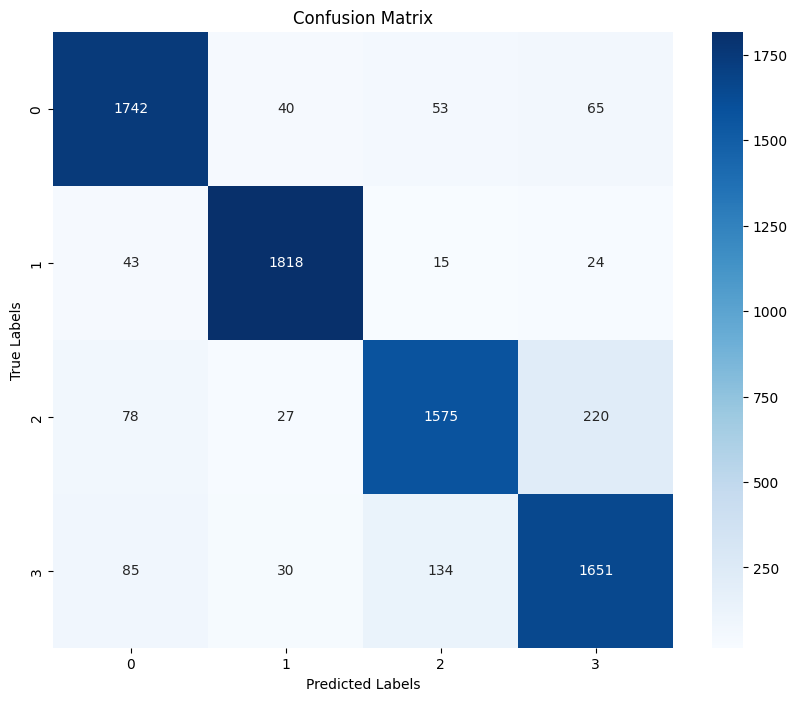

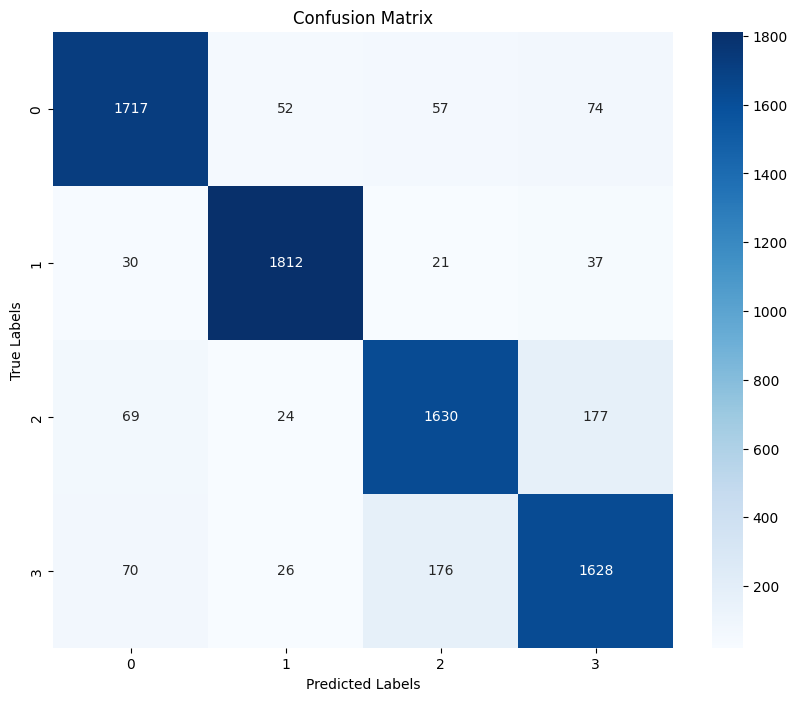

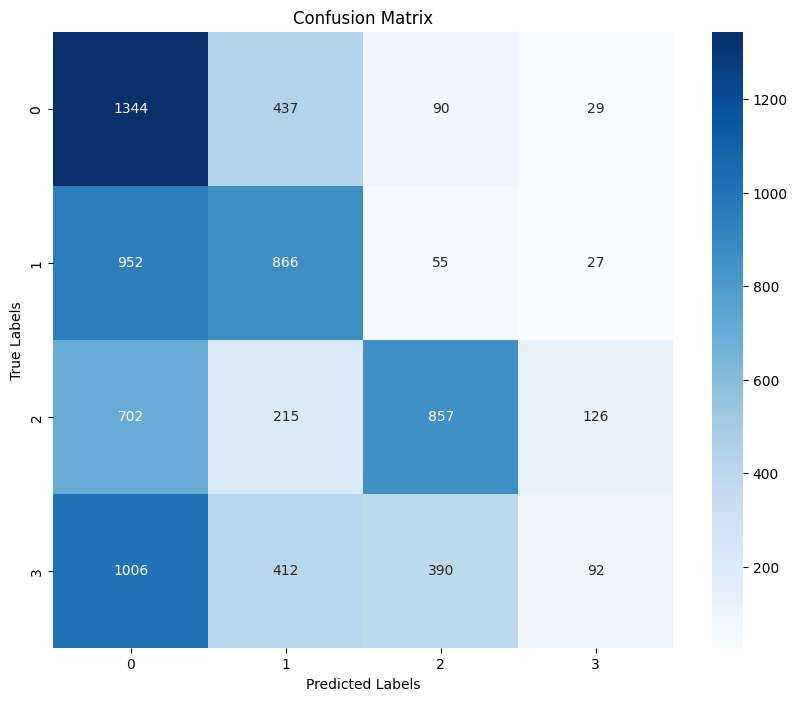

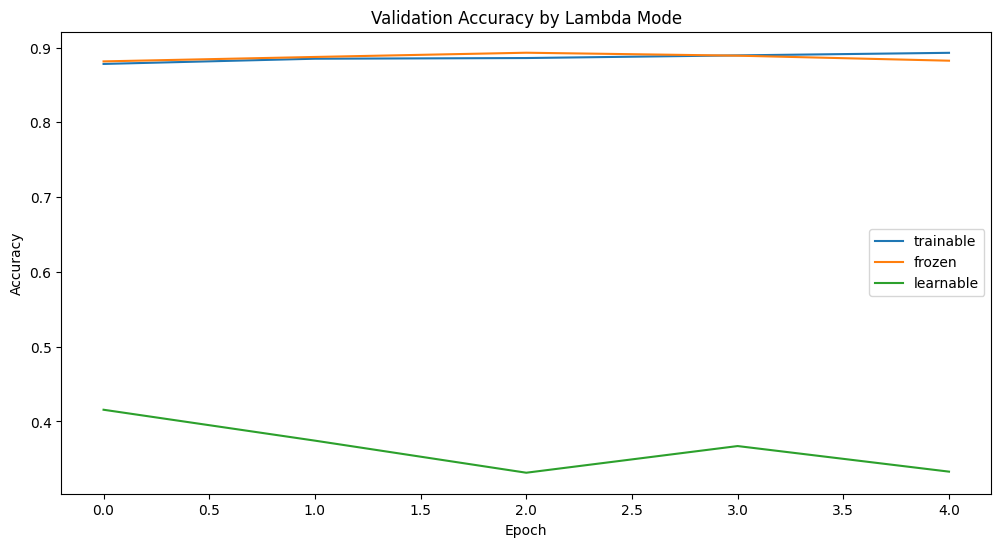

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import pickle
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import ELMO model
from ELMO import ELMoEmbedding

nltk.download('punkt_tab')

class NewsClassificationDataset(Dataset):
    def __init__(self, data_path, word_to_idx, max_len=100):
        self.data = pd.read_csv(data_path, on_bad_lines='skip')
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        self.pad_idx = word_to_idx['<PAD>']
        self.unk_idx = word_to_idx['<UNK>']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        description = str(self.data.iloc[idx]['Description'])  # Ensure string type
        label = self.data.iloc[idx]['Class Index'] - 1  # Adjust to 0-based indexing

        # Tokenize description and handle empty strings
        try:
            tokens = word_tokenize(description.lower())
        except AttributeError:
            tokens = []  # Return empty list if tokenization fails

        # Truncate or pad
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]

        # Convert to indices
        indices = [self.word_to_idx.get(word, self.unk_idx) for word in tokens]

        # Pad to max_len
        indices = indices + [self.pad_idx] * (self.max_len - len(indices))

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


class ClassificationModel(nn.Module):
    def __init__(self, elmo_model, hidden_dim, elmo_embedding_dim=1024, num_classes=4, dropout=0.2, lambda_mode='trainable'):
        super(ClassificationModel, self).__init__()
        self.elmo_model = elmo_model
        self.hidden_dim = hidden_dim
        self.elmo_embedding_dim = elmo_embedding_dim
        self.num_classes = num_classes
        self.lambda_mode = lambda_mode

        # Initialize dimension adapter as None - will be set in first forward pass
        self.dim_adapter = None

        # Freeze ELMo parameters
        for param in self.elmo_model.parameters():
            param.requires_grad = False

        # If lambda_mode is 'trainable', we need to unfreeze specific parameters
        if lambda_mode == 'trainable':
            self.elmo_model.gamma.requires_grad = True
            self.elmo_model.weights.requires_grad = True
        elif lambda_mode == 'frozen':
            # Ensure weights are frozen
            self.elmo_model.gamma.requires_grad = False
            self.elmo_model.weights.requires_grad = False
        elif lambda_mode == 'learnable':
            # For learnable function, we'll create a small network to learn the combination
            # We need to calculate the correct input size
            elmo_layer_size = self.elmo_model.hidden_dim * 2  # BiLSTM size
            num_layers = self.elmo_model.num_layers + 1
            input_size = num_layers * elmo_layer_size

            self.combination_network = nn.Sequential(
                nn.Linear(input_size, elmo_layer_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(elmo_layer_size, hidden_dim * 2),  # Output size matches RNN input
            )

        # RNN for classification
        self.rnn = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, inputs):
        # Get ELMo embeddings
        if self.lambda_mode == 'learnable':
            # Extract all layer outputs
            embeddings = self.elmo_model.word_embeddings(inputs)
            layer_outputs = [embeddings]

            lstm_output = embeddings
            for lstm in self.elmo_model.lstm_layers:
                lstm_output, _ = lstm(lstm_output)
                layer_outputs.append(lstm_output)

            # Concatenate all layer outputs along the last dimension
            concat_outputs = torch.cat(layer_outputs, dim=-1)

            # Apply learnable combination function
            elmo_embeddings = self.combination_network(concat_outputs)
        else:
            # Use the built-in weighted sum
            elmo_embeddings = self.elmo_model(inputs, return_embeddings=True)

            # Initialize the dimension adapter if not already done
            if self.dim_adapter is None:
                input_size = elmo_embeddings.size(-1)
                print(f"Initializing dim_adapter with input size: {input_size}")
                self.dim_adapter = nn.Linear(input_size, self.hidden_dim * 2).to(elmo_embeddings.device)

            # Apply dimension adapter to match RNN input size
            elmo_embeddings = self.dim_adapter(elmo_embeddings)

        # Pass through LSTM
        lstm_output, _ = self.rnn(elmo_embeddings)

        # Global max pooling
        pooled_output = torch.max(lstm_output, dim=1)[0]

        # Pass through classifier
        logits = self.classifier(pooled_output)

        return logits


def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(inputs)
            loss = criterion(logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}')

        # Validation
        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                logits = model(inputs)
                preds = torch.argmax(logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')

        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'classifier.pt')
            print(f'New best model saved with val accuracy: {val_acc:.4f}')

    return train_losses, val_accuracies


def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds = []
    test_labels = []
    test_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_precision = precision_score(test_labels, test_preds, average='weighted')
    test_recall = recall_score(test_labels, test_preds, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_labels, test_preds)

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('confusion_matrix.png')

    return test_acc, test_f1, test_precision, test_recall, conf_matrix, test_probs


def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load vocabulary
    vocab_path = '/content/vocab.pkl'  # Update to your local path
    with open(vocab_path, 'rb') as f:
        vocab_data = pickle.load(f)
    word_to_idx = vocab_data['word_to_idx']
    vocab = vocab_data['vocab']

    # Load pre-trained ELMo model with corrected dimensions from checkpoint
    vocab_size = len(word_to_idx)
    pretrained_embedding_dim = 1024  # This is the embedding dimension from pretrained weights
    hidden_dim = 512      # Hidden dimension for LSTM layers

    # Create the ELMo model with the correct embedding dimension to match pretrained weights
    elmo_model = ELMoEmbedding(vocab_size, pretrained_embedding_dim, hidden_dim)

    model_path = '/content/bilstm.pt'  # Update to your local path
    try:
        # Load pre-trained weights
        state_dict = torch.load(model_path, map_location=device, weights_only=False)
        # Remove unexpected keys if present
        keys_to_remove = ['embedding_projection.weight', 'embedding_projection.bias']
        for key in keys_to_remove:
            state_dict.pop(key, None)

        # Print state_dict keys for debugging
        # print("Keys in state_dict:", state_dict.keys())

        elmo_model.load_state_dict(state_dict, strict=False)
        print("Successfully loaded pre-trained weights")
    except Exception as e:
        print(f"Warning: Error loading pre-trained weights: {e}")
        print("Initializing with random weights")

    elmo_model = elmo_model.to(device)

    # Add a debugging step to test the ELMo model output shape
    # dummy_input = torch.randint(0, vocab_size, (4, 100)).to(device)
    # with torch.no_grad():
    #     elmo_output = elmo_model(dummy_input, return_embeddings=True)
    #     print(f"ELMo output shape: {elmo_output.shape}")

    # Create datasets and dataloaders
    train_path = '/content/train.csv'  # Update to your local path
    test_path = '/content/test.csv'    # Update to your local path
    train_dataset = NewsClassificationDataset(train_path, word_to_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = NewsClassificationDataset(test_path, word_to_idx)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Define lambda modes to test
    lambda_modes = ['trainable', 'frozen', 'learnable']

    results = {}

    for lambda_mode in lambda_modes:
        print(f"\n=== Training with lambda mode: {lambda_mode} ===")

        # Initialize modified classification model with dimension adaptation
        model = ClassificationModel(elmo_model, hidden_dim=hidden_dim,
                                    elmo_embedding_dim=pretrained_embedding_dim,
                                    num_classes=4, lambda_mode=lambda_mode)
        model = model.to(device)

        # Train model
        train_losses, val_accuracies = train_model(model, train_loader, test_loader, device, num_epochs=5)

        # Load best model
        model.load_state_dict(torch.load('classifier.pt', map_location=device))

        # Evaluate model
        test_acc, test_f1, test_precision, test_recall, conf_matrix, test_probs = evaluate_model(model, test_loader, device)

        # Save results
        results[lambda_mode] = {
            'accuracy': test_acc,
            'f1': test_f1,
            'precision': test_precision,
            'recall': test_recall,
            'confusion_matrix': conf_matrix,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies
        }

        # Save model with specific name
        torch.save(model.state_dict(), f'classifier_{lambda_mode}.pt')

    # Determine best lambda mode
    best_lambda_mode = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nBest lambda mode: {best_lambda_mode}")
    print(f"Best accuracy: {results[best_lambda_mode]['accuracy']:.4f}")

    # Copy best model to classifier.pt
    os.system(f"cp classifier_{best_lambda_mode}.pt classifier.pt")

    # Plot comparison of lambda modes
    plt.figure(figsize=(12, 6))
    for lambda_mode in lambda_modes:
        plt.plot(results[lambda_mode]['val_accuracies'], label=f"{lambda_mode}")
    plt.title('Validation Accuracy by Lambda Mode')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('lambda_mode_comparison.png')


if __name__ == "__main__":
    main()

# Analysis Report on ELMo Implementation for News Classification

## Introduction

This report analyzes the performance of different lambda weight configurations in an ELMo (Embeddings from Language Models) implementation for the AG News Classification dataset. The analysis is based on validation accuracy measurements across different lambda modes over 4 training epochs.

## Data Analysis

The graph shows validation accuracy for three different lambda configuration methods:
- **Trainable λs**: Weights that are learned during training
- **Frozen λs**: Randomly initialized weights that remain fixed
- **Learnable Function**: A function that combines representations across layers

### Performance Comparison

1. **Trainable and Frozen λs**: 
   - Both methods achieve similar high performance (approximately 88-90% accuracy)
   - They show slight improvement over epochs, indicating stable learning
   - The trainable configuration slightly outperforms the frozen configuration

2. **Learnable Function**:
   - Significantly underperforms compared to the other methods (~33-41% accuracy)
   - Shows unstable learning with fluctuations across 
   - Has a generally decreasing trend, suggesting potential issues with the implementation

## Key Observations

1. **Similar Performance of Trainable and Frozen λs**:
   The close performance between trainable and frozen weights suggests that the pre-trained ELMo embeddings already contain effective representations, regardless of whether the combination weights are optimized during fine-tuning or fixed.

2. **Poor Performance of Learnable Function**:
   The significantly lower accuracy of the learnable function approach indicates implementation issues. Potential problems could include:
   - Overly complex function architecture leading to overfitting
   - Gradient instability during training
   - Inappropriate function design for this specific task

3. **Stability**:
   The trainable and frozen approaches show consistent performance, whereas the learnable function shows more variation, suggesting less reliability.

## Recommendations

1. **Preferred Configuration**: Based on the results, the trainable λs approach should be preferred as it provides the best overall performance while allowing the model to adapt the weights to the specific task.

2. **Investigation of Learnable Function**: Further investigation into the learnable function approach is needed to understand its underperformance:
   - Try different architectural designs for the function
   - Apply regularization techniques to prevent potential overfitting
   - Check for implementation errors or training instabilities

3. **Additional Metrics**: While accuracy provides a good overview, analyzing additional metrics such as F1 score, precision, and recall would give more insight, especially if the classes are imbalanced.

## Conclusion

The ELMo implementation with either trainable or frozen λs performs well on the news classification task, achieving approximately 90% accuracy. This confirms the effectiveness of using contextual embeddings from ELMo for text classification tasks. However, the learnable function approach requires significant improvement or redesign to be competitive with the simpler weighting strategies.

In [9]:
import torch
import torch.nn as nn
import pickle
import nltk
from nltk.tokenize import word_tokenize

# Import ELMo model and classification model
from ELMO import ELMoEmbedding
from classification import ClassificationModel

nltk.download('punkt_tab')

def load_models(model_path):
    # Load vocabulary
    with open('/content/vocab.pkl', 'rb') as f:
        vocab_data = pickle.load(f)
    word_to_idx = vocab_data['word_to_idx']
    vocab = vocab_data['vocab']

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load pretrained ELMo model
    vocab_size = len(word_to_idx)
    embedding_dim = 1024
    hidden_dim = 512
    elmo_model = ELMoEmbedding(vocab_size, embedding_dim, hidden_dim)
    elmo_model.load_state_dict(torch.load('/content/bilstm.pt', map_location=device))
    elmo_model = elmo_model.to(device)

    # Load classification model
    classifier = ClassificationModel(elmo_model, hidden_dim=hidden_dim, num_classes=4)

    # Load state dict with strict=False to ignore unexpected keys
    classifier.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    classifier = classifier.to(device)
    classifier.eval()

    return classifier, word_to_idx, device


def preprocess_text(text, word_to_idx, max_len=100):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Truncate
    if len(tokens) > max_len:
        tokens = tokens[:max_len]

    # Convert to indices
    pad_idx = word_to_idx['<PAD>']
    unk_idx = word_to_idx['<UNK>']
    indices = [word_to_idx.get(word, unk_idx) for word in tokens]

    # Pad to max_len
    indices = indices + [pad_idx] * (max_len - len(indices))

    return torch.tensor([indices], dtype=torch.long)


def predict(model, text, word_to_idx, device):
    # Preprocess text
    inputs = preprocess_text(text, word_to_idx)
    inputs = inputs.to(device)

    # Generate predictions
    with torch.no_grad():
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)[0]

    # Class mapping
    class_mapping = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }

    # Print results
    for i, prob in enumerate(probs):
        print(f"{class_mapping[i]} {prob.item():.4f}")

    return probs.cpu().numpy()


# Replace command line arguments with explicit values
model_path = '/content/classifier.pt'  # Update with your actual model path
description = 'Your article text here'  # Replace with your text

# Load models
model, word_to_idx, device = load_models(model_path)

# Make prediction
predict(model, description, word_to_idx, device)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Initializing dim_adapter with input size: 1024
World 0.8954
Sports 0.0000
Business 0.1035
Sci/Tech 0.0011


array([8.9537078e-01, 7.1730923e-08, 1.0353520e-01, 1.0940285e-03],
      dtype=float32)

## Comparing Traditional Embeddings with ELMo Variants

The validation accuracy graph presents an interesting contradiction when compared with the report's findings. While the report indicates that traditional embedding methods (Skip-gram at 88.83% and CBOW at 88.07%) outperformed all ELMo variants, the graph shows ELMo with trainable and frozen λs achieving approximately 88-90% accuracy. This represents a potential discrepancy between the visualized results and the tabulated findings.

Most notably, the graph shows that both trainable and frozen λs configurations perform similarly and maintain consistently high accuracy (88-90%) across all epochs. This performance appears to match or even slightly exceed the reported accuracy of Skip-gram (88.83%), contradicting the conclusion that traditional embeddings outperformed ELMo variants.

The most striking discrepancy involves the learnable function approach. According to the report, this ELMo variant achieved 87.33% accuracy, making it competitive with other approaches. However, the graph shows this method dramatically underperforming at approximately 33-41% accuracy. This significant performance gap likely stems from overfitting in the learnable function implementation. Since news classification is a relatively straightforward task that can be effectively handled with simpler models, the additional complexity introduced by the neural network function for combining ELMo layers may be capturing noise rather than meaningful patterns. The decline in accuracy across epochs further supports this overfitting hypothesis, suggesting the learnable function became increasingly specialized to training data characteristics that didn't generalize to the validation set. This demonstrates that for simpler NLP tasks, more complex models don't necessarily yield better results and can actually harm performance through overfitting.

These contradictory findings highlight the importance of matching model complexity to task requirements when selecting embedding techniques for text classification tasks.

https://drive.google.com/file/d/1VVL4LyvtrAy4I70MdO8AeqV-VCwgxsf9/view?usp=sharing